In [2]:
#Load libraries

# data manipulation libraries
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# statistical libraries
import scipy.stats as stats
from statistics import mean 
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# misc. libraries
import glob
import os
from datetime import datetime, timedelta



In [ ]:

## ONLY RUN TO RE-CREATE HDD AND CDD VERIFICATION FILES ###

# if you run, be sure all wdd.daily files are located in the directory to aggregate verification. Also be sure to chance
# directy paths

file_type = 'HDD'
os.chdir('/Users/seanbratton/Desktop/Github_Repo/CFS_ECMWF_COMPARE/data')
path = '/Users/seanbratton/Desktop/Github_Repo/CFS_ECMWF_COMPARE/data/wdd.daily.20190326.csv'
all_ver_files = glob.glob(path+"/*.csv")
li = []
for filename in all_ver_files:
    data1= pd.read_csv(filename, usecols=["DATE","FLAG","WEIGHT","PARAM","VALUE","10Y_NORMAL","30Y_NORMAL"])#,nrows=4)
    param_id = data1.loc[(data1.PARAM == file_type) & (data1.FLAG == "A")]
    verification  = param_id.iloc[2:]
    li.append(verification) 
df = pd.concat(li,axis=0)
df.set_index("DATE", inplace = True)
sorted_df = df.sort_index()
print(sorted_df)

# output CDD/HDD verification file
sorted_df.to_csv('/Users/seanbratton/Desktop/Github_Repo/CFS_ECMWF_COMPARE/full_verification_{}.csv'.format(file_type))

In [3]:
### SCRIPT TO COMPILE DATA ###

# This currently compiles the 16-20 day forecast
day_range_1 = 16 # day 1 of forecast period range
day_range_2 = 20 # day 2 of forecast period range

# only CDDs are aggregated
period_input = 'CDD' # CDD or HDD

# identify verification file for HDD or CDD
if period_input == 'HDD':
    path = '/Users/seanbratton/Desktop/Github_Repo/CFS_ECMWF_COMPARE/full_verification_HDD.csv'
elif period_input =='CDD': 
    path = '/Users/seanbratton/Desktop/Github_Repo/CFS_ECMWF_COMPARE/full_verification_CDD.csv'   
data1= pd.read_csv(path)

# format date column correctly
data1['DATE'] = pd.to_datetime(data1['DATE'], format='%Y-%m-%d')

# create new data columns for data attribution
data1['CFS_FCT'] = ''
data1['VER_AGG'] = ''
data1['Climo_Period_30y'] = ''
data1['Climo_Period_10y'] = ''

# change directory to access CFS files
os.chdir('/Users/seanbratton/Desktop/Github_Repo/CFS_ECMWF_Compare/data/CFS.20130827.csv')

#CFS Forecast attribution
for i in range(len(data1)):
    totals = 0
    for x in range(day_range_1, day_range_2+1):
        day_delta = data1.DATE[i] #- timedelta(days=x)
        day_delta_fmt = day_delta.strftime('%Y%m%d')
        try:
            model_file = pd.read_csv('CFS.{}.csv'.format(str(day_delta_fmt)))
            fct_day = model_file.value.loc[(model_file.fday == x) & (model_file.param == period_input)]
            day_value = float(fct_day.values[0])
            totals = day_value + totals 
        except:
            print("CFS FCT")
            print("forecast out of bounds")
            totals = np.nan

    data1.CFS_FCT[i] = float(totals) # compile CFS forecast day for desired period


#30-year climo attribution
for i in range(len(data1)):
    totals = 0
    for x in range(day_range_1, day_range_2+1):
        try:
            day_delta = data1.DATE[i] + timedelta(days=x)
            day_delta_fmt = day_delta.strftime('%Y%m%d')
            day_value_data = data1.loc[data1.DATE == day_delta_fmt]
            day_value = day_value_data['30Y_NORMAL'].values[0]
            totals = day_value + totals 
        except:
            totals = 0

     # compile 30-year climo for desired period        
    if totals != 0:
        data1.Climo_Period_30y[i] = float(totals)
    else:
        data1.Climo_Period_30y[i] = np.nan


#10-year climo attribution
for i in range(len(data1)):
    totals = 0
    for x in range(day_range_1, day_range_2+1):
        try:
            day_delta = data1.DATE[i] + timedelta(days=x)
            day_delta_fmt = day_delta.strftime('%Y%m%d')
            day_value_data = data1.loc[data1.DATE == day_delta_fmt]
            day_value = day_value_data['10Y_NORMAL'].values[0]
            totals = day_value + totals 
        except:
            totals = 0

    # compile 10-year climo for desired period         
    if totals != 0:
        data1.Climo_Period_10y[i] = float(totals)
    else:
        data1.Climo_Period_10y[i] = np.nan

# Verification Attribution
for i in range(len(data1)):
    totals = 0
    for x in range(day_range_1, day_range_2+1):
        try:
            day_delta = data1.DATE[i] + timedelta(days=x)
            day_delta_fmt = day_delta.strftime('%Y%m%d')
            day_value_data = data1.loc[data1.DATE == day_delta_fmt]
            day_value = day_value_data['VALUE'].values[0]
            totals = day_value + totals 
        except:
            totals = 0

    # compile verification for desired period       
    if totals != 0:
        data1.VER_AGG[i] = float(totals) 
    else:
        data1.VER_AGG[i] = np.nan


data1 = data1.dropna() # drop all rows that contain an NaN value


# calculated anomalies and other verification metrics
data1['CFS_anom_fct'] = data1['CFS_FCT'] - data1['Climo_Period_30y'] # CFS anomaly (compared to 30-year climo)
data1['ver_anom'] = data1['VER_AGG'] - data1['Climo_Period_30y'] # Verification anomaly (compared to 30-year climo)
data1['model_vs_ver'] = data1['CFS_anom_fct'] - data1['ver_anom'] # CFS comparison to verification -# = lower value, +# = higher value
data1['per_error'] = (abs(data1['CFS_FCT'] - data1['VER_AGG'])/data1['VER_AGG'])*100 # percent error of forecast using verification


print(data1)

/var/folders/7z/zvdlnbkj3073y5v9tyz6f6b80000gn/T/ipykernel_998/807742729.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.CFS_FCT[i] = float(totals) # compile CFS forecast day for desired period
/var/folders/7z/zvdlnbkj3073y5v9tyz6f6b80000gn/T/ipykernel_998/807742729.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.CFS_FCT[i] = float(totals) # compile CFS forecast day for desired period
/var/folders/7z/zvdlnbkj3073y5v9tyz6f6b80000gn/T/ipykernel_998/807742729.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

           DATE FLAG WEIGHT PARAM     VALUE  10Y_NORMAL  30Y_NORMAL  \
0    2019-03-25    A    POP   CDD  0.874978    0.768209    0.564460   
1    2019-03-26    A    POP   CDD  0.561169    0.776870    0.610885   
2    2019-03-27    A    POP   CDD  0.237674    0.806777    0.614850   
3    2019-03-28    A    POP   CDD  0.366923    0.812292    0.631436   
4    2019-03-29    A    POP   CDD  0.592833    0.842698    0.636754   
...         ...  ...    ...   ...       ...         ...         ...   
1500 2023-05-03    A    POP   CDD  1.710623    2.764987    2.498915   
1501 2023-05-04    A    POP   CDD  1.603044    2.856380    2.586673   
1502 2023-05-05    A    POP   CDD  2.393780    2.936663    2.684919   
1503 2023-05-06    A    POP   CDD  3.263858    2.993159    2.779350   
1504 2023-05-07    A    POP   CDD  3.925029    3.070136    2.895471   

        CFS_FCT    VER_AGG Climo_Period_30y Climo_Period_10y CFS_anom_fct  \
0      3.535477     8.3464          5.24426         6.745872    -1.708

/var/folders/7z/zvdlnbkj3073y5v9tyz6f6b80000gn/T/ipykernel_998/807742729.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.VER_AGG[i] = np.nan
/var/folders/7z/zvdlnbkj3073y5v9tyz6f6b80000gn/T/ipykernel_998/807742729.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['CFS_anom_fct'] = data1['CFS_FCT'] - data1['Climo_Period_30y'] # CFS anomaly (compared to 30-year climo)
/var/folders/7z/zvdlnbkj3073y5v9tyz6f6b80000gn/T/ipykernel_998/807742729.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Check Seasonal
Check CDD
1133   2022-05-01
1134   2022-05-02
1135   2022-05-03
1136   2022-05-04
1137   2022-05-05
          ...    
1312   2022-10-27
1313   2022-10-28
1314   2022-10-29
1315   2022-10-30
1316   2022-10-31
Name: DATE, Length: 184, dtype: datetime64[ns]
DATE                0
FLAG                0
WEIGHT              0
PARAM               0
VALUE               0
10Y_NORMAL          0
30Y_NORMAL          0
CFS_FCT             0
VER_AGG             0
Climo_Period_30y    0
Climo_Period_10y    0
CFS_anom_fct        0
ver_anom            0
model_vs_ver        0
per_error           0
dtype: int64
r2 (coef of determination) score is 0.9059896118637742
mean_sqrd_error is== 45.69680764052749
root_mean_squared error of is== 6.75994139327609
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:

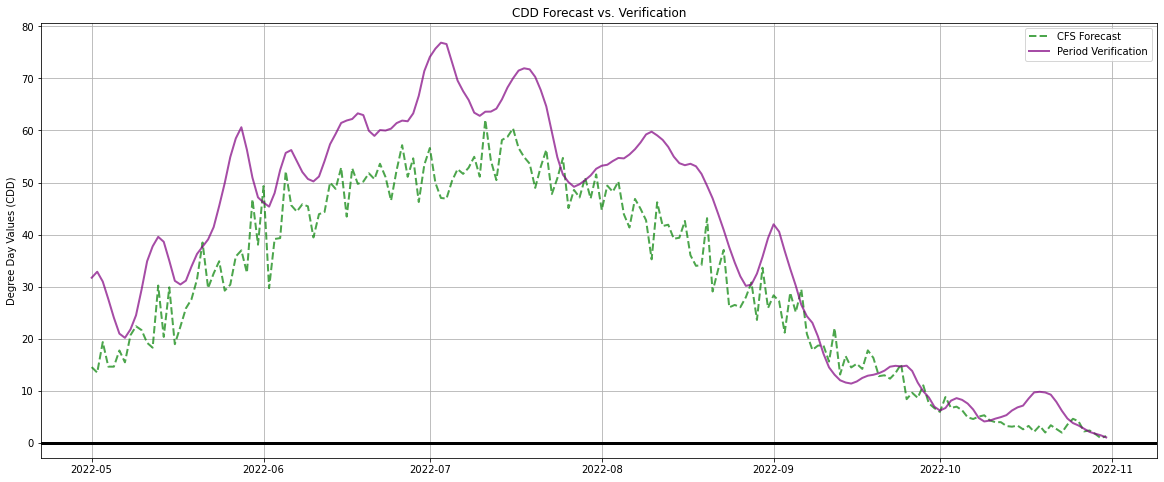

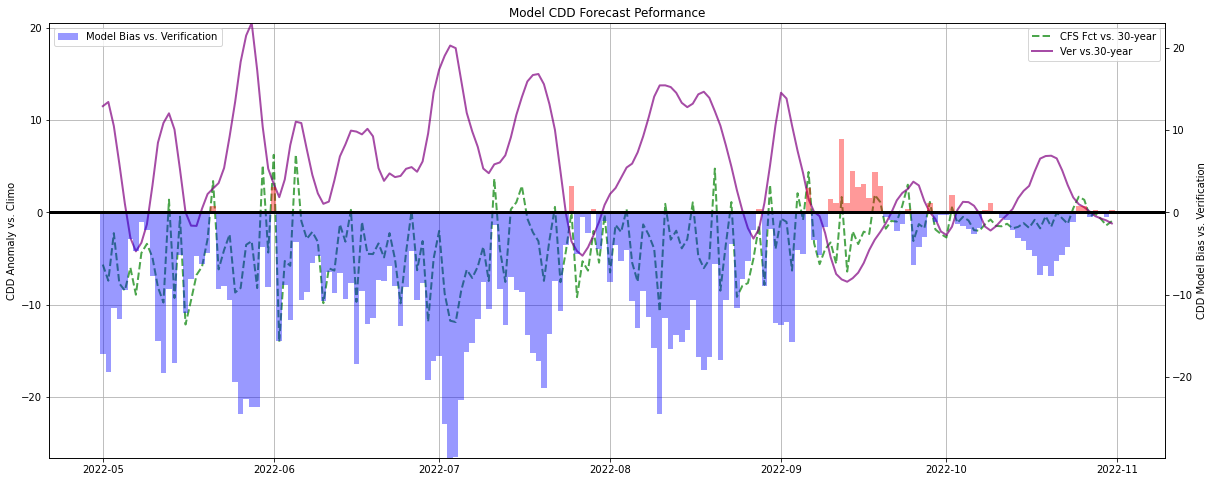

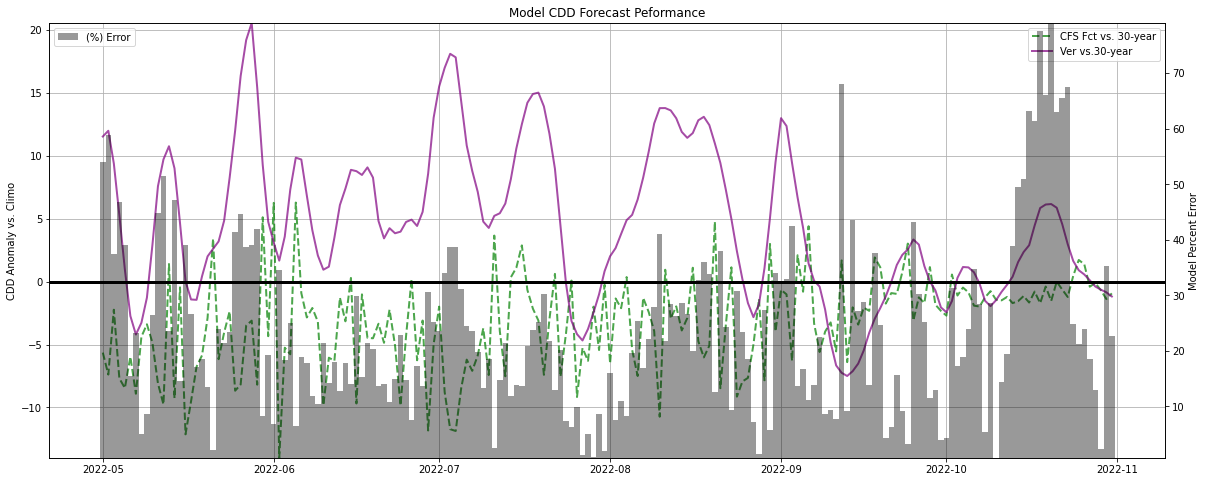

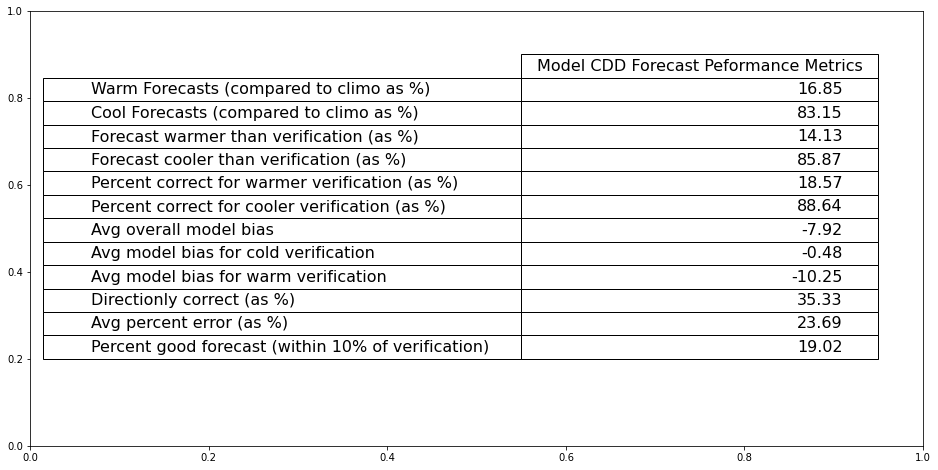

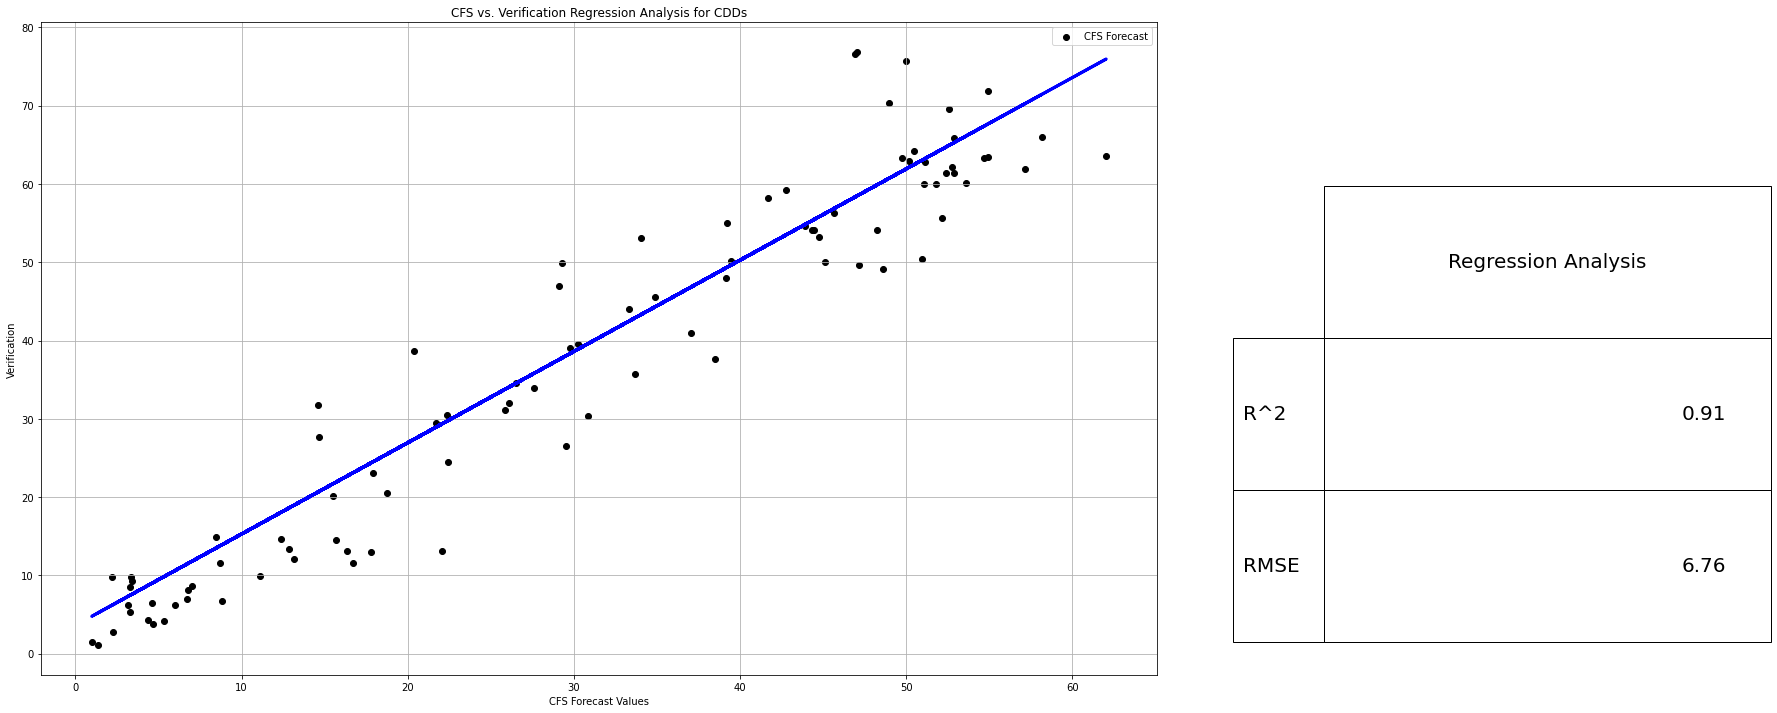

Text(0.5, 1.0, 'Model vs. Verification Attribution (% of samples)')

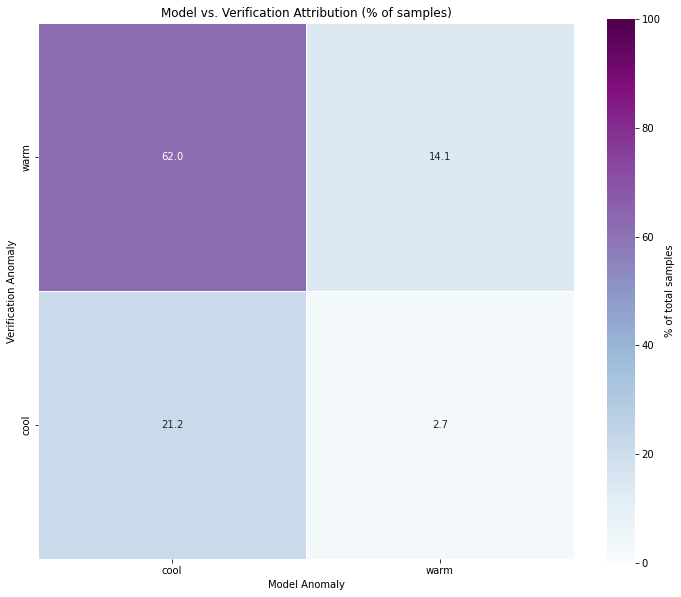

In [4]:
# Data visualizations for a single time period

# this will only aggregate data for a specific season (enter year) or month (enter month)

time_scale_n = 'seasonal' # identify as monthly or seasonal (cooling or heating season)
year_input = 2022 # year selection for period
month_input = 12 # month selection for period (if applicable - using montly time scale)

if time_scale_n == 'monthly': # using only this month)
    print('Check monthly')
    data1_sub = data1.loc[(data1.DATE.dt.year == year_input) & (data1.DATE.dt.month == month_input)]

elif time_scale_n == 'seasonal': # use all months associated with CDD or HDD seaason
    print('Check Seasonal')
    if period_input == 'HDD':
        print('Check HDD')
        data1_sub = data1.loc[((data1.DATE.dt.year == year_input) & (data1.DATE.dt.month >= 11)) |
                              ((data1.DATE.dt.year == year_input+1) & (data1.DATE.dt.month <= 4))]
    elif period_input == "CDD":
        print('Check CDD')
        data1_sub = data1.loc[((data1.DATE.dt.year == year_input) & (data1.DATE.dt.month >= 5) &
                               (data1.DATE.dt.month <= 10))]

print(data1_sub.DATE)

# stat regimes if for HDDs
if period_input == 'HDD':
  
    per_warmer = (len(data1_sub.loc[data1_sub.model_vs_ver < 0])/len(data1_sub))*100
    per_cooler = (len(data1_sub.loc[data1_sub.model_vs_ver > 0])/len(data1_sub))*100
    per_cooler_30year = (len(data1_sub.loc[data1_sub.CFS_anom_fct > 0])/len(data1_sub))*100
    per_warmer_30year = (len(data1_sub.loc[data1_sub.CFS_anom_fct < 0])/len(data1_sub))*100
    per_correct_colder =(len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub.loc[(data1_sub.ver_anom > 0)]))*100
    per_correct_warmer =(len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub.loc[(data1_sub.ver_anom < 0)]))*100
    avg_bias = mean(data1_sub.model_vs_ver)
    avg_bias_cold = mean(data1_sub.model_vs_ver.loc[data1_sub.ver_anom > 0])
    avg_bias_warm = mean(data1_sub.model_vs_ver.loc[data1_sub.ver_anom < 0])
    per_dir_cor = (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0)) | 
                                 ((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/len(data1_sub))*100
    avg_per_error = mean(data1_sub.per_error)
    per_good_fct = (len(data1_sub.loc[data1_sub.per_error <= 10])/len(data1_sub))*100
    
    # color identifier for bars
    colors = ['r' if x < 0 else 'b' for x in data1_sub.model_vs_ver]

# stat regimes if for CDDs
if period_input == 'CDD':
    per_warmer = (len(data1_sub.loc[data1_sub.model_vs_ver > 0])/len(data1_sub))*100
    per_cooler = (len(data1_sub.loc[data1_sub.model_vs_ver < 0])/len(data1_sub))*100
    per_cooler_30year = (len(data1_sub.loc[data1_sub.CFS_anom_fct < 0])/len(data1_sub))*100
    per_warmer_30year = (len(data1_sub.loc[data1_sub.CFS_anom_fct > 0])/len(data1_sub))*100
    per_correct_colder =(len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub.loc[(data1_sub.ver_anom < 0)]))*100
    per_correct_warmer =(len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub.loc[(data1_sub.ver_anom > 0)]))*100
    avg_bias = mean(data1_sub.model_vs_ver)
    avg_bias_cold = mean(data1_sub.model_vs_ver.loc[data1_sub.ver_anom < 0])
    avg_bias_warm = mean(data1_sub.model_vs_ver.loc[data1_sub.ver_anom > 0])
    per_dir_cor = (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0)) | 
                                 ((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/len(data1_sub))*100
    avg_per_error = mean(data1_sub.per_error)
    per_good_fct = (len(data1_sub.loc[data1_sub.per_error <= 10])/len(data1_sub))*100

    # color identifier for bars
    colors = ['r' if x > 0 else 'b' for x in data1_sub.model_vs_ver]

# set mins and maxs for axes
if data1_sub.ver_anom.min() < data1_sub.CFS_anom_fct.min():
    min_y = data1_sub.ver_anom.min()
else:
    min_y = data1_sub.CFS_anom_fct.min()

if data1_sub.ver_anom.max() > data1_sub.CFS_anom_fct.max():
    max_y = data1_sub.ver_anom.max()
else:
    max_y = data1_sub.CFS_anom_fct.max()

# function to align both y-axes
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)

# plot raw CFS and Verification data
fig, ax1 = plt.subplots(figsize = (20,8))

ax1.plot(data1_sub.DATE, data1_sub.CFS_FCT, color = 'green', alpha = 0.7, linestyle='dashed', linewidth = 2.0 ) 
ax1.plot(data1_sub.DATE, data1_sub.VER_AGG, color = 'purple', alpha = 0.7, linestyle='solid', linewidth = 2.0 ) 
ax1.grid() # create grid
plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=3.0)
ax1.set_ylabel('Degree Day Values ({})'.format(period_input)) # set y-label
ax1.legend(['CFS Forecast','Period Verification'], loc="upper right")
ax1.set_title('{} Forecast vs. Verification'.format(period_input))

# Plot CFS and verification vs. climo. Graph also plots model bias vs. verification (model was too cold or warm)
fig, ax1 = plt.subplots(figsize = (20,8))

# CFS and verification vs. climo graph
ax1.plot(data1_sub.DATE, data1_sub.CFS_anom_fct, color = 'green', alpha = 0.7, linestyle='dashed', linewidth = 2.0 ) 
ax1.plot(data1_sub.DATE, data1_sub.ver_anom, color = 'purple', alpha = 0.7, linestyle='solid', linewidth = 2.0 ) 
ax1.grid() # create grid
ax1.set_ylabel('{} Anomaly vs. Climo'.format(period_input)) # set y-label
ax1.set_ylim(min_y, max_y)# set y-range
ax1.legend(['CFS Fct vs. 30-year','Ver vs.30-year'], loc="upper right")
ax1.set_title('Model {} Forecast Peformance'.format(period_input))

ax2 = ax1.twinx()

# model bias bar graph
ax2.bar(data1_sub.DATE, data1_sub.model_vs_ver, color=colors, width = 1, alpha = 0.4)
ax2.set_ylabel('{} Model Bias vs. Verification'.format(period_input)) # set y-label
ax2.set_ylim(data1_sub.model_vs_ver.min(), data1_sub.model_vs_ver.max())# set y-range
ax2.legend(['Model Bias vs. Verification'], loc="upper left")
plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=3.0)
align_yaxis(ax1, ax2)


# Same as above, but also includes percent error
fig, ax1 = plt.subplots(figsize = (20,8))

# CFS and verification vs. climo
ax1.plot(data1_sub.DATE, data1_sub.CFS_anom_fct, color = 'green', alpha = 0.7, linestyle='dashed', linewidth = 2.0 ) 
ax1.plot(data1_sub.DATE, data1_sub.ver_anom, color = 'purple', alpha = 0.7, linestyle='solid', linewidth = 2.0 ) 
ax1.grid() # create grid
plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=3.0)
ax1.set_ylabel('{} Anomaly vs. Climo'.format(period_input)) # set y-label
ax1.set_ylim(min_y, max_y)# set y-range
ax1.legend(['CFS Fct vs. 30-year','Ver vs.30-year'], loc="upper right")
ax1.set_title('Model {} Forecast Peformance'.format(period_input))

ax2 = ax1.twinx()

# secondary y for percent error visualizations
ax2.bar(data1_sub.DATE, data1_sub.per_error, color='k', width = 1, alpha = 0.4)
ax2.set_ylabel('Model Percent Error') # set y-label
ax2.set_ylim(data1_sub.per_error.min(), data1_sub.per_error.max())# set y-range
ax2.legend(['(%) Error'], loc="upper left")

# plot data table to show statistics for period
fig, ax1 = plt.subplots(figsize = (16,8)) 

# table labels
col_labels=['Model {} Forecast Peformance Metrics'.format(period_input)]
row_labels=['Warm Forecasts (compared to climo as %)', 'Cool Forecasts (compared to climo as %)','Forecast warmer than verification (as %)','Forecast cooler than verification (as %)',
                'Percent correct for warmer verification (as %)','Percent correct for cooler verification (as %)','Avg overall model bias','Avg model bias for cold verification', 'Avg model bias for warm verification',
                'Directionly correct (as %)','Avg percent error (as %)', 'Percent good forecast (within 10% of verification)'
            ]

# table values
table_vals=[[round(per_warmer_30year,2)],[round(per_cooler_30year,2)], [round(per_warmer,2)],[round(per_cooler,2)], 
            [round(per_correct_warmer,2)],[round(per_correct_colder,2)],[round(avg_bias,2)],[round(avg_bias_cold,2)],[round(avg_bias_warm,2)],[round(per_dir_cor,2)],
            [round(avg_per_error,2)], [round(per_good_fct,2)]
                
            ] 
  
# table format
the_table = plt.table(cellText=table_vals,
                  colWidths = [1.2]*2,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', bbox=[0.55, 0.2, 0.4, 0.7])
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)

##### STATISTICAL AND REGRESSION ANALYSIS

pd.to_numeric(data1_sub['CFS_FCT'], errors='coerce')
pd.to_numeric(data1_sub['VER_AGG'], errors='coerce')

print(data1_sub.isna().sum())

# feature(s) dataset
X_data= data1_sub[["CFS_FCT"]] 

# target dataset
y_data= data1_sub["VER_AGG"]

# define training and test data sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X_data, y_data,
                                                test_size=0.5, train_size=0.5)

# initiate and run linear model
model = LinearRegression(fit_intercept=True) # instantiate model
model.fit(Xtrain, ytrain)  # fit model to data - needs to be applied to training data
y_model = model.predict(Xtest) # use model to predict target variable (y) using set of feature variables (x)


# testing meterics
r2_scores = model.score(Xtrain, ytrain) # R^2 value
print('r2 (coef of determination) score is',r2_scores) 
print('mean_sqrd_error is==',mean_squared_error(ytest,y_model)) # find RMSE between target testing and modeled dataset
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(ytest,y_model))) # print score
Xtrain = Xtrain.squeeze()
model_ols = sm.OLS(ytrain.values.astype(float),sm.add_constant(Xtrain.values.astype(float))).fit() #sm.add_constant(Xtrain)).fit()

# run same linear regression using sm.OLS
y_pred = model_ols.fittedvalues
print_summary = model_ols.summary()
print(print_summary)

# Plot outputs for linear regression model
fig, ax1 = plt.subplots(figsize = (20,12))
ax1.scatter(Xtest, ytest, color="black")
ax1.plot(Xtest.squeeze(), y_model, color="blue", linewidth=3)

ax1.grid() # create grid

ax1.set_ylabel('Verification') # set y-label
ax1.set_xlabel('CFS Forecast Values') # set y-label
ax1.legend(['CFS Forecast'], loc="upper right")
ax1.set_title('CFS vs. Verification Regression Analysis for {}s'.format(period_input))

# table setup/labels
col_labels=['Regression Analysis']
row_labels=['R^2   ','RMSE   ']

# table values
table_vals=[[round(r2_scores,2)],[round(np.sqrt(mean_squared_error(ytest,y_model)),2)]
                
            ] 

# table format   
the_table = plt.table(cellText=table_vals,
                  colWidths = [1.2]*2,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='bottom right', bbox=[1.15, 0.05, 0.4, 0.7])
the_table.auto_set_font_size(False)
the_table.set_fontsize(20)

plt.show()

### Heatmap for sample distribution (as a % of total samples)
if period_input == 'CDD':
    warm_cool= (len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub))*100


    cool_cool = (len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub))*100


    warm_warm = (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub))*100

    cool_warm = (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub))*100


if period_input == 'HDD':
    warm_cool= (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub))*100


    cool_cool = (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub))*100


    warm_warm = (len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub))*100

    cool_warm = (len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub))*100


cum_matrix = np.array([[warm_cool,warm_warm],[cool_cool,cool_warm]])


plt.subplots(figsize=(12, 10))

cmap = "BuPu" 

# create heatmap for defined periods                                 
sns.heatmap(cum_matrix,annot=True, fmt=".1f", yticklabels= ['warm','cool'], xticklabels= ['cool', 'warm'],
          cbar_kws={'label': '% of total samples'}, cmap = cmap, vmin=0, vmax=100, # (3) 
           square=True,linewidth=1)  # (4)

# heatmap labels
plt.ylabel('Verification Anomaly')
plt.xlabel('Model Anomaly')
plt.title('Model vs. Verification Attribution (% of samples)')



           DATE FLAG WEIGHT PARAM     VALUE  10Y_NORMAL  30Y_NORMAL  \
37   2019-05-01    A    POP   CDD  3.632989    2.563882    2.011816   
38   2019-05-02    A    POP   CDD  3.423314    2.675907    2.065179   
39   2019-05-03    A    POP   CDD  2.962785    2.756965    2.180716   
40   2019-05-04    A    POP   CDD  2.959201    2.818941    2.247050   
41   2019-05-05    A    POP   CDD  2.440187    2.894932    2.365261   
...         ...  ...    ...   ...       ...         ...         ...   
1500 2023-05-03    A    POP   CDD  1.710623    2.764987    2.498915   
1501 2023-05-04    A    POP   CDD  1.603044    2.856380    2.586673   
1502 2023-05-05    A    POP   CDD  2.393780    2.936663    2.684919   
1503 2023-05-06    A    POP   CDD  3.263858    2.993159    2.779350   
1504 2023-05-07    A    POP   CDD  3.925029    3.070136    2.895471   

        CFS_FCT    VER_AGG Climo_Period_30y Climo_Period_10y CFS_anom_fct  \
37    10.880583    23.7698        18.554879         22.53633    -7.674

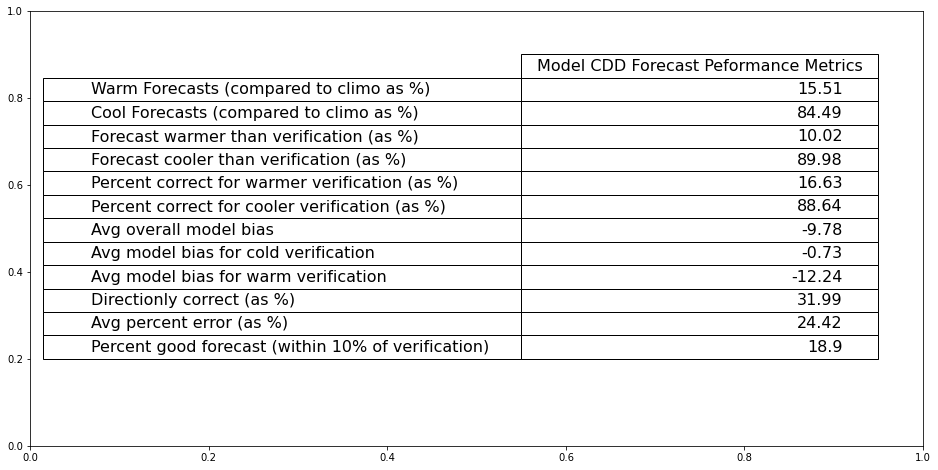

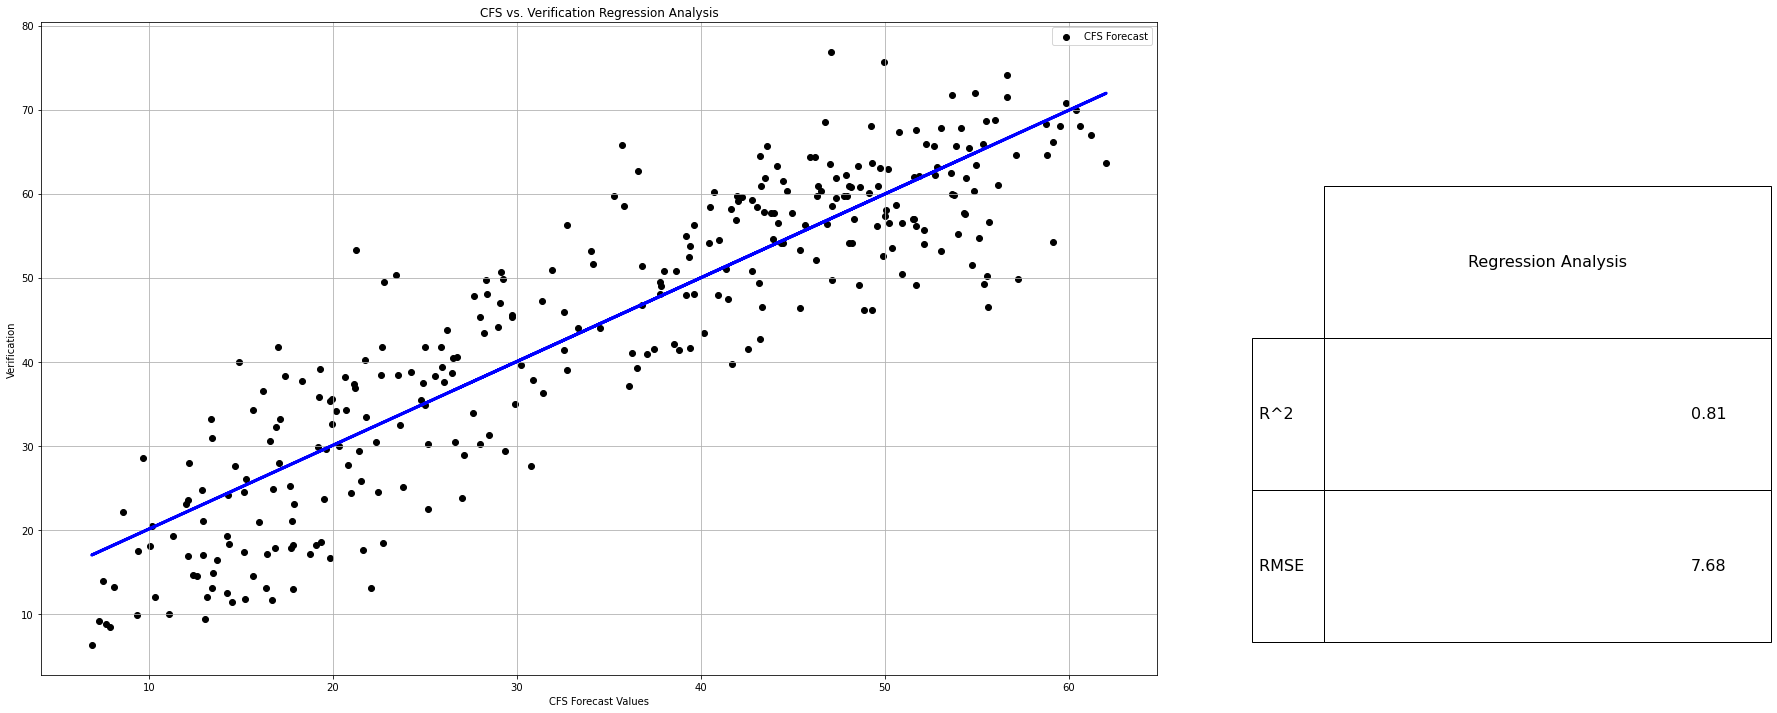

Text(0.5, 1.0, 'Model vs. Verification Attribution (% of samples)')

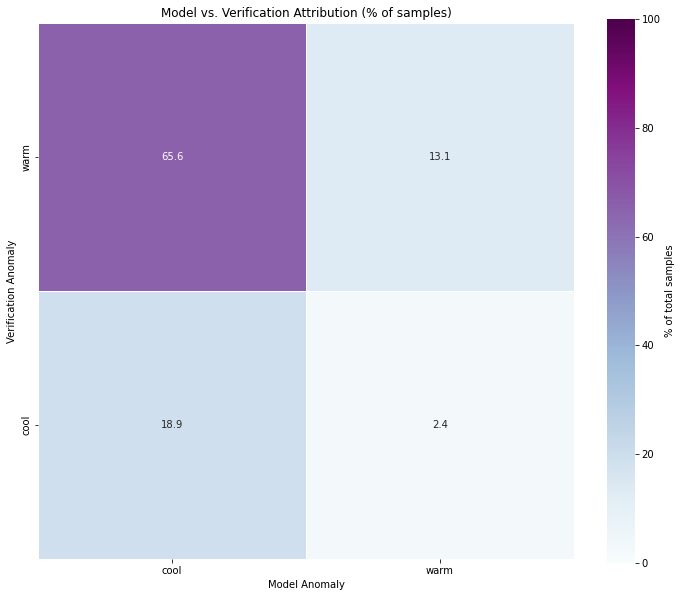

In [5]:

### CUMULATIVE ASSESSMENT ####

# this script IS THE SAME AS ABOVE but will evaluate all years for the desired months instead of an isolated period
# for a specific year

months_analy = [5,6,7,8,9] # select periods (months that you want to evaluate)

# only select data that is consistent with month selection above
list_TF = data1.DATE.dt.month.isin(months_analy)
index_list = [i for i, x in enumerate(list_TF) if x]
data1_sub = data1.iloc[index_list]

print(data1_sub)

# stat calculations for HDDs
if period_input == 'HDD':
    per_warmer = (len(data1_sub.loc[data1_sub.model_vs_ver < 0])/len(data1_sub))*100
    per_cooler = (len(data1_sub.loc[data1_sub.model_vs_ver > 0])/len(data1_sub))*100
    per_cooler_30year = (len(data1_sub.loc[data1_sub.CFS_anom_fct > 0])/len(data1_sub))*100
    per_warmer_30year = (len(data1_sub.loc[data1_sub.CFS_anom_fct < 0])/len(data1_sub))*100
    per_correct_colder =(len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub.loc[(data1_sub.ver_anom > 0)]))*100
    per_correct_warmer =(len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub.loc[(data1_sub.ver_anom < 0)]))*100
    avg_bias = mean(data1_sub.model_vs_ver)
    avg_bias_cold = mean(data1_sub.model_vs_ver.loc[data1_sub.ver_anom > 0])
    avg_bias_warm = mean(data1_sub.model_vs_ver.loc[data1_sub.ver_anom < 0])
    per_dir_cor = (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0)) | 
                                 ((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/len(data1_sub))*100
    avg_per_error = mean(data1_sub.per_error)
    per_good_fct = (len(data1_sub.loc[data1_sub.per_error <= 10])/len(data1_sub))*100
    
# stat calculations for HDDs
if period_input == 'CDD':
    # Stat Calculations
    per_warmer = (len(data1_sub.loc[data1_sub.model_vs_ver > 0])/len(data1_sub))*100
    per_cooler = (len(data1_sub.loc[data1_sub.model_vs_ver < 0])/len(data1_sub))*100
    per_cooler_30year = (len(data1_sub.loc[data1_sub.CFS_anom_fct < 0])/len(data1_sub))*100
    per_warmer_30year = (len(data1_sub.loc[data1_sub.CFS_anom_fct > 0])/len(data1_sub))*100
    per_correct_colder =(len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub.loc[(data1_sub.ver_anom < 0)]))*100
    per_correct_warmer =(len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub.loc[(data1_sub.ver_anom > 0)]))*100
    avg_bias = mean(data1_sub.model_vs_ver)
    avg_bias_cold = mean(data1_sub.model_vs_ver.loc[data1_sub.ver_anom < 0])
    avg_bias_warm = mean(data1_sub.model_vs_ver.loc[data1_sub.ver_anom > 0])
    per_dir_cor = (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0)) | 
                                 ((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/len(data1_sub))*100
    avg_per_error = mean(data1_sub.per_error)
    per_good_fct = (len(data1_sub.loc[data1_sub.per_error <= 10])/len(data1_sub))*100

# table plot
fig, ax1 = plt.subplots(figsize = (16,8)) 

# table labels
col_labels=['Model {} Forecast Peformance Metrics'.format(period_input)]
row_labels=['Warm Forecasts (compared to climo as %)', 'Cool Forecasts (compared to climo as %)','Forecast warmer than verification (as %)','Forecast cooler than verification (as %)',
                'Percent correct for warmer verification (as %)','Percent correct for cooler verification (as %)','Avg overall model bias','Avg model bias for cold verification', 'Avg model bias for warm verification',
                'Directionly correct (as %)','Avg percent error (as %)', 'Percent good forecast (within 10% of verification)'
            ]

# table values
table_vals=[[round(per_warmer_30year,2)],[round(per_cooler_30year,2)], [round(per_warmer,2)],[round(per_cooler,2)], 
            [round(per_correct_warmer,2)],[round(per_correct_colder,2)],[round(avg_bias,2)],[round(avg_bias_cold,2)],[round(avg_bias_warm,2)],[round(per_dir_cor,2)],
            [round(avg_per_error,2)], [round(per_good_fct,2)]
                
            ] 

# table format 
the_table = plt.table(cellText=table_vals,
                  colWidths = [1.2]*2,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', bbox=[0.55, 0.2, 0.4, 0.7])
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)

##### STATISTICAL AND REGRESSION ANALYSIS

pd.to_numeric(data1_sub['CFS_FCT'], errors='coerce')
pd.to_numeric(data1_sub['VER_AGG'], errors='coerce')

print(data1_sub.isna().sum())

# feature(s) dataset
X_data= data1_sub[["CFS_FCT"]] 

# target dataset
y_data= data1_sub["VER_AGG"]

# training and testing datasets split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_data, y_data,
                                                test_size=0.5, train_size=0.5)

# initiate and run linear model

model = LinearRegression(fit_intercept=True) # instantiate model
model.fit(Xtrain, ytrain)  # fit model to data - needs to be applied to training data
y_model = model.predict(Xtest) # use model to predict target variable (y) using set of feature variables (x)


# testing meterics
r2_scores = model.score(Xtrain, ytrain) # R^2 value
print('r2 (coef of determination) score is',r2_scores) 
print('mean_sqrd_error is==',mean_squared_error(ytest,y_model)) # find RMSE between target testing and modeled dataset
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(ytest,y_model))) # print score
Xtrain = Xtrain.squeeze()

# run secondary linear regression using sm.OLS to get stat summary table
model_ols = sm.OLS(ytrain.values.astype(float),sm.add_constant(Xtrain.values.astype(float))).fit() #s

y_pred = model_ols.fittedvalues
print_summary = model_ols.summary()
print(print_summary)

# Regression results output
fig, ax1 = plt.subplots(figsize = (20,12))
ax1.scatter(Xtest, ytest, color="black")
ax1.plot(Xtest.squeeze(), y_model, color="blue", linewidth=3)
ax1.grid() # create grid
ax1.set_ylabel('Verification') # set y-label
ax1.set_xlabel('CFS Forecast Values') # set y-label
ax1.legend(['CFS Forecast'], loc="upper right")
ax1.set_title('CFS vs. Verification Regression Analysis')

# table labels
col_labels=['Regression Analysis']
row_labels=['R^2   ','RMSE   ']

# table values 
table_vals=[[round(r2_scores,2)],[round(np.sqrt(mean_squared_error(ytest,y_model)),2)]
                
            ] 

 # table format   
the_table = plt.table(cellText=table_vals,
                  colWidths = [1.1]*2,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='bottom right', bbox=[1.15, 0.05, 0.4, 0.7])
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)

plt.show()


### Heatmap for sample distribution
if period_input == 'CDD':
    warm_cool= (len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub))*100


    cool_cool = (len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub))*100


    warm_warm = (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub))*100

    cool_warm = (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub))*100


if period_input == 'HDD':
    warm_cool= (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub))*100


    cool_cool = (len(data1_sub.loc[((data1_sub.CFS_anom_fct > 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub))*100


    warm_warm = (len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom < 0))])/
                         len(data1_sub))*100

    cool_warm = (len(data1_sub.loc[((data1_sub.CFS_anom_fct < 0) & (data1_sub.ver_anom > 0))])/
                         len(data1_sub))*100

# matrix of values for cool/cool, warm/cool, warm/warm, cool/warm
cum_matrix = np.array([[warm_cool,warm_warm],[cool_cool,cool_warm]])


plt.subplots(figsize=(12, 10))

cmap = "BuPu" 

# create heatmap of percentage values                                
sns.heatmap(cum_matrix,annot=True, fmt=".1f", yticklabels= ['warm','cool'], xticklabels= ['cool', 'warm'],
          cbar_kws={'label': '% of total samples'}, cmap = cmap, vmin=0, vmax=100, # (3) 
           square=True,linewidth=1)  # (4)


plt.ylabel('Verification Anomaly')
plt.xlabel('Model Anomaly')
plt.title('Model vs. Verification Attribution (% of samples)')


